In [5]:
import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt

In [158]:
# let's load the IRMAS dataset
IRMAS = scipy.io.loadmat('IRMAS_small.mat')
data = IRMAS['data']

X = data[0:10,0:-1:16]

X_q = np.round(X,decimals=2)

quants = np.unique(X_q)
nquants = quants.shape[0]

N,D = X_q.shape

X = np.zeros((N,D,nquants,1))

for i in xrange(N):
    for j in xrange(D):
        i_hot = np.where(X_q[i,j] == quants) 
        X[i,j,i_hot[0][0]] = 1
        
Y = X[:,-1,:,:].reshape(X.shape[0],X.shape[2])
X = X[:,0:-1,:,:]

N,D,_,_ = X.shape

X_tr = X[0:7,:,:,:]
Y_tr = Y[0:7,:]
X_ts = X[7:,:,:,:]
Y_ts = Y[7:,:]

print X_tr.shape
print Y_tr.shape
print X_ts.shape
print Y_ts.shape

(7, 2756, 94, 1)
(7, 94)
(3, 2756, 94, 1)
(3, 94)


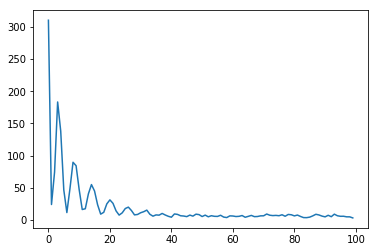

training accuracy is: 28.5714285714
test accuracy is: 0.0


In [162]:
lr = 0.5
gamma = 0.01

X_tf = tf.placeholder("float", [None,D,nquants,1])
y_tf = tf.placeholder("float", [None,nquants])

C1D = 2
C1ch = 3
C2D = 1
C2ch = 4

W1 = tf.Variable(tf.truncated_normal([C1D,nquants,1,C1ch],stddev=0.01))
W2 = tf.concat([tf.truncated_normal([C2D,1,C1ch,C2ch],stddev=0.01), 
                tf.zeros((1,1,C1ch,C2ch)),
               tf.truncated_normal([C2D,1,C1ch,C2ch],stddev=0.01)],0)
Wo = tf.Variable(tf.truncated_normal([int(round(D/4))*C2ch,nquants],stddev=0.01))

C1_out = tf.nn.conv2d(X_tf, W1, strides=[1,1,nquants,1],padding = 'SAME')
C1_out = tf.nn.relu(C1_out)
C2_out = tf.nn.conv2d(C1_out,W2, strides = [1,4,1,1],padding = 'SAME' )
C2_out = tf.nn.relu(C2_out)

C2_out_flat = tf.reshape(C2_out,[-1,int(round(D/4))*C2ch])

scores = tf.matmul(C2_out_flat,Wo)

y_hat = tf.nn.softmax(scores)

# loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=scores,labels=y_tf)
                     + gamma*tf.nn.l2_loss(W1) + gamma*tf.nn.l2_loss(W2) + 
                     gamma*tf.nn.l2_loss(Wo))

train_step = tf.train.AdamOptimizer(lr).minimize(loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

nepochs = 100

loss_t = np.zeros((1,nepochs))

# this is our training 
for e in xrange(nepochs):
    step = sess.run(train_step,feed_dict={X_tf: X_tr, y_tf: Y_tr})
    curr_loss = sess.run(loss,feed_dict={X_tf: X_tr, y_tf: Y_tr})
    loss_t[0,e] = curr_loss
    
plt.plot(loss_t.T)
plt.show()

curr_scores = sess.run(scores,feed_dict={X_tf: X_tr, y_tf: Y_tr})
y_hat_correct = np.argmax(curr_scores,axis=1)
y_correct = np.argmax(Y_tr,axis=1)

print "training accuracy is: " + str(100.0*np.sum(y_hat_correct == y_correct)/Y_tr.shape[0])

curr_scores = sess.run(scores,feed_dict={X_tf: X_ts, y_tf: Y_ts})
y_hat_correct = np.argmax(curr_scores,axis=1)
y_correct = np.argmax(Y_ts,axis=1)

print "test accuracy is: " + str(100.0*np.sum(y_hat_correct == y_correct)/Y_ts.shape[0])

sess.close()

In [152]:
loss_t[0,-1]

4.600594520568848